# **O Desafio**

O naufr√°gio do Titanic √© um dos naufr√°gios mais infames da hist√≥ria.

Em 15 de abril de 1912, durante sua viagem inaugural, o amplamente considerado "inafund√°vel" RMS Titanic afundou ap√≥s colidir com um iceberg. Infelizmente, n√£o havia botes salva-vidas suficientes para todos a bordo, resultando na morte de 1502 dos 2224 passageiros e tripulantes.

Embora houvesse algum elemento de sorte envolvido na sobreviv√™ncia, parece que alguns grupos de pessoas tinham mais probabilidade de sobreviver do que outros.

Neste desafio, pedimos que voc√™ construa um modelo preditivo que responda √† pergunta: ‚Äúque tipos de pessoas tinham mais probabilidade de sobreviver?‚Äù usando dados de passageiros (ou seja, nome, idade, sexo, classe socioecon√¥mica, etc.).

## Avalia√ß√£o

## Meta
√â seu trabalho prever se um passageiro sobreviveu ao naufr√°gio do Titanic ou n√£o.
Para cada um no conjunto de teste, voc√™ deve prever um valor 0 ou 1 para a vari√°vel.

## M√©trica
Sua pontua√ß√£o √© a porcentagem de passageiros que voc√™ prev√™ corretamente. Isso √© conhecido como precis√£o .

## Formato do arquivo de submiss√£o
Voc√™ deve enviar um arquivo csv com exatamente 418 entradas mais uma linha de cabe√ßalho. Seu envio mostrar√° um erro se voc√™ tiver colunas extras (al√©m de PassengerId e Survived) ou linhas.

#### O arquivo deve ter exatamente 2 colunas:

- PassengerId (classificado em qualquer ordem)
- Sobreviveu (cont√©m suas previs√µes bin√°rias: 1 para sobreviveu, 0 para falecido)

## Descri√ß√£o do conjunto de dados

### Vis√£o geral

#### Os dados foram divididos em dois grupos:

- conjunto de treinamento (train.csv)
- conjunto de teste (test.csv)

## Dicion√°rio de Dados

### Vari√°vel Defini√ß√£o
- sobreviv√™ncia -	Sobreviv√™ncia
- pclass - Classe de ingresso
- sexo - Sexo
- Idade -	Idade em anos
- irm√£o	- # de irm√£os/c√¥njuges a bordo do Titanic
- ressecar - # de pais/crian√ßas a bordo do Titanic
- bilhete	- N√∫mero do bilhete
- tarifa	- Tarifa de passageiro
- cabine	- N√∫mero da cabine
- embarcado -	Porto de embarque

### Notas Vari√°veis
- pclass : Um proxy para status socioecon√¥mico (SES)
  - 1¬∫ = Alto
  - 2¬∫ = M√©dio
  - 3¬∫ = Baixo

- idade : A idade √© fracion√°ria se for menor que 1. Se a idade for estimada, ela est√° no formato de xx,5

- sibsp : O conjunto de dados define as rela√ß√µes familiares desta forma...
  - Irm√£o = irm√£o, irm√£, meio-irm√£o, meia-irm√£
  - C√¥njuge = marido, esposa (amantes e noivos foram ignorados)

- parch : O conjunto de dados define as rela√ß√µes familiares desta forma...
  - Pai = m√£e, pai
  - Filho = filha, filho, enteada, enteado
  - Algumas crian√ßas viajaram apenas com
  uma bab√°, portanto parch=0 para elas.

# Setup

In [1]:
%%capture
%pip install ydata-profiling
%pip install catboost

In [ ]:
import pandas as pd
import ydata_profiling
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV


import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Data Clean

In [62]:
raw_df_train = pd.read_csv('/content/drive/MyDrive/Projetos/Data Science/0 Projeto /Dados/train.csv')

raw_df_test = pd.read_csv('/content/drive/MyDrive/Projetos/Data Science/0 Projeto /Dados/test.csv')

y_real = pd.read_csv('/content/drive/MyDrive/Projetos/Data Science/0 Projeto /Dados/gender_submission.csv')

In [4]:
raw_df_train.profile_report()

Output hidden; open in https://colab.research.google.com to view.

In [5]:
(
    raw_df_train.groupby('Sex')['Survived']
    .value_counts(normalize=True)
    .mul(100)  # Multiplica por 100 para percentual
    .round(2)  # Arredonda para 2 casas decimais
    .unstack()
    .astype(str) + '%'  # Converte para string e adiciona '%'
)

Survived       0       1
Sex                     
female     25.8%   74.2%
male      81.11%  18.89%

In [6]:
raw_df_train.groupby('SibSp')['Survived'].value_counts().unstack().assign(

    # Adiciona uma coluna como total
    Total=lambda raw_df_train: raw_df_train.sum(axis=1),

    # % de sobreviventes
    Sobreviventes=lambda raw_df_train: (raw_df_train[1] / raw_df_train['Total'] * 100).round(2).astype(str) + '%',

    # % de n√£o sobreviventes
    N√£o_Sobreviventes=lambda raw_df_train: (raw_df_train[0] / raw_df_train['Total'] * 100).round(2).astype(str) + '%'
  )

Survived      0      1  Total Sobreviventes N√£o_Sobreviventes
SibSp                                                        
0         398.0  210.0  608.0        34.54%            65.46%
1          97.0  112.0  209.0        53.59%            46.41%
2          15.0   13.0   28.0        46.43%            53.57%
3          12.0    4.0   16.0         25.0%             75.0%
4          15.0    3.0   18.0        16.67%            83.33%
5           5.0    NaN    5.0          nan%            100.0%
8           7.0    NaN    7.0          nan%            100.0%

In [7]:
# Definir faixas et√°rias
bins = [0, 12, 18, 30, 45, 60, 100]
labels = ['Crian√ßa (0-12)', 'Adolescente (13-18)', 'Jovem Adulto (19-30)',
          'Adulto (31-45)', 'Meia Idade (46-60)', 'Idoso (61+)']

# N√∫mero total de passageiros
total_geral = raw_df_train.shape[0]

# Agrupar por faixas et√°rias sem criar uma nova coluna
(
  raw_df_train.groupby([
      pd.cut(
          raw_df_train['Age'],
          bins=bins,
          labels=labels
          ),
      'Pclass'
      ])['Survived']
  .value_counts()
  .unstack().assign(

    # Adiciona uma coluna como total
    Total=lambda raw_df_train: raw_df_train.sum(axis=1),

    # % de sobreviventes
    Sobreviventes=lambda raw_df_train: (raw_df_train[1] / raw_df_train['Total'] * 100).round(2).astype(str) + '%',

    # % de n√£o sobreviventes
    N√£o_Sobreviventes=lambda raw_df_train: (raw_df_train[0] / raw_df_train['Total'] * 100).round(2).astype(str) + '%',

    # % do total geral de passageiros (independente da faixa et√°ria)
    Total_Geral_Percent=lambda raw_df_train: (raw_df_train['Total'] / total_geral * 100).round(2).astype(str) + '%'
  )
)

<ipython-input-7-553263385e8c>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  raw_df_train.groupby([


Survived                       0   1  Total Sobreviventes N√£o_Sobreviventes  \
Age                  Pclass                                                   
Crian√ßa (0-12)       1         1   3      4         75.0%             25.0%   
                     2         0  17     17        100.0%              0.0%   
                     3        28  20     48        41.67%            58.33%   
Adolescente (13-18)  1         1  11     12        91.67%             8.33%   
                     2         6   6     12         50.0%             50.0%   
                     3        33  13     46        28.26%            71.74%   
Jovem Adulto (19-30) 1        13  32     45        71.11%            28.89%   
                     2        39  28     67        41.79%            58.21%   
                     3       122  36    158        22.78%            77.22%   
Adulto (31-45)       1        17  46     63        73.02%            26.98%   
                     2        29  25     54         46.3%             53.7%   
                     3        70  15     85        17.65%            82.35%   
Meia Idade (46-60)   1        21  27     48        56.25%            43.75%   
                     2        14   6     20         30.0%             70.0%   
                     3        13   0     13          0.0%            100.0%   
Idoso (61+)          1        11   3     14        21.43%            78.57%   
                     2         2   1      3        33.33%            66.67%   
                     3         4   1      5         20.0%             80.0%   

Survived                    Total_Geral_Percent  
Age                  Pclass                      
Crian√ßa (0-12)       1                    0.45%  
                     2                    1.91%  
                     3                    5.39%  
Adolescente (13-18)  1                    1.35%  
                     2                    1.35%  
                     3                    5.16%  
Jovem Adulto (19-30) 1                    5.05%  
                     2                    7.52%  
                     3                   17.73%  
Adulto (31-45)       1                    7.07%  
                     2                    6.06%  
                     3                    9.54%  
Meia Idade (46-60)   1                    5.39%  
                     2                    2.24%  
                     3                    1.46%  
Idoso (61+)          1                    1.57%  
                     2                    0.34%  
                     3                    0.56%

Sabendo disto agora vamos tratar os dados

<Axes: >

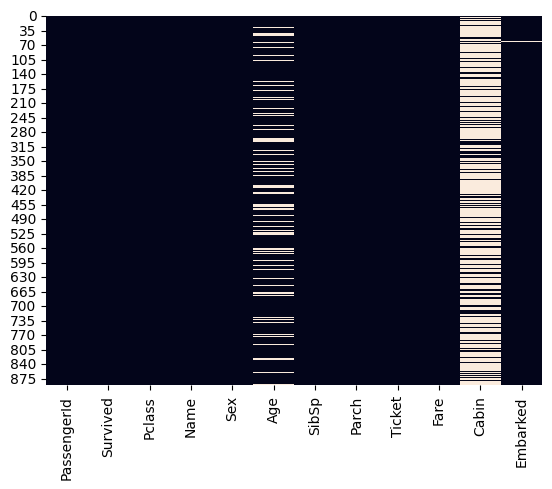

In [8]:
sns.heatmap(raw_df_train.isnull(), cbar=False)

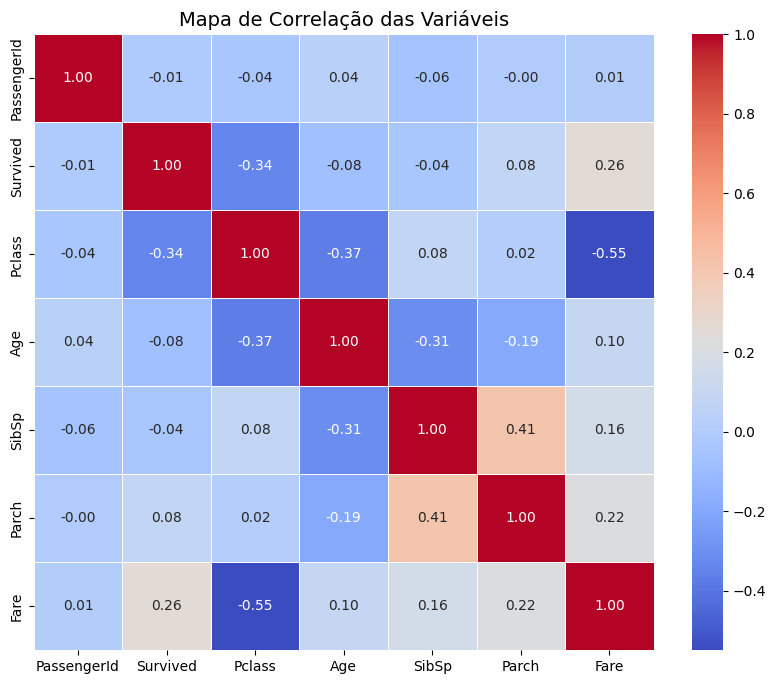

In [9]:
# Calcular a matriz de correla√ß√£o
correlation_matrix = raw_df_train.corr(numeric_only=True)

# Criar o heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# T√≠tulo do gr√°fico
plt.title("Mapa de Correla√ß√£o das Vari√°veis", fontsize=14)
plt.show()

In [10]:
# raw_df_train['Age'].interpolate()
raw_df_train['Age'] = raw_df_train.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))

raw_df_train['Embarked'] = raw_df_train['Embarked'].fillna(raw_df_train['Embarked'].mode()[0])

raw_df_train.drop('Cabin', axis=1, inplace=True)

In [11]:
# Criando o objeto LabelEncoder
lb = LabelEncoder()

# Aplicando o LabelEncoder para cada coluna de tipo 'object'
for col in raw_df_train.select_dtypes(include=['object']).columns:
    raw_df_train[col] = lb.fit_transform(raw_df_train[col])

# Verificando o resultado
raw_df_train.head()

PassengerId  Survived  Pclass  Name  Sex   Age  SibSp  Parch  Ticket  \
0            1         0       3   108    1  22.0      1      0     523   
1            2         1       1   190    0  38.0      1      0     596   
2            3         1       3   353    0  26.0      0      0     669   
3            4         1       1   272    0  35.0      1      0      49   
4            5         0       3    15    1  35.0      0      0     472   

      Fare  Embarked  
0   7.2500         2  
1  71.2833         0  
2   7.9250         2  
3  53.1000         2  
4   8.0500         2

In [12]:
# Calcular a informa√ß√£o m√∫tua
mi = mutual_info_classif(raw_df_train.drop(columns=['Survived']), raw_df_train['Survived'])

# Criando um DataFrame para exibir as informa√ß√µes m√∫tuas
mi_df = pd.DataFrame({
    'Feature': raw_df_train.drop(columns=['Survived']).columns,
    'Mutual Information': mi
})

mi_df.sort_values(by='Mutual Information', ascending=False)

Feature  Mutual Information
3          Sex            0.136698
8         Fare            0.133377
7       Ticket            0.116203
1       Pclass            0.061569
4          Age            0.053444
6        Parch            0.042691
9     Embarked            0.041458
5        SibSp            0.033162
0  PassengerId            0.020517
2         Name            0.000000

In [13]:
# Ordenando as vari√°veis pela informa√ß√£o m√∫tua (maior valor primeiro)
mi_df_sorted = mi_df.sort_values(by='Mutual Information', ascending=False)

# Selecionando as 5 vari√°veis mais representativas (maior informa√ß√£o m√∫tua)
# Caso o n√∫mero de vari√°veis seja menor que 5, ele pega todas as vari√°veis
top_5_features = mi_df_sorted.head(5)['Feature']

# Criando um novo DataFrame com as vari√°veis mais representativas
raw_df_selected = raw_df_train[top_5_features]

# Usando o merge para adicionar a coluna 'Survived' com base no √≠ndice
raw_df_selected = raw_df_selected.merge(raw_df_train[['Survived']], left_index=True, right_index=True)

In [14]:
raw_df_selected.head()

Sex     Fare  Ticket  Pclass   Age  Survived
0    1   7.2500     523       3  22.0         0
1    0  71.2833     596       1  38.0         1
2    0   7.9250     669       3  26.0         1
3    0  53.1000      49       1  35.0         1
4    1   8.0500     472       3  35.0         0

In [15]:
raw_df_test['Age'] = raw_df_test.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))

raw_df_test['Embarked'] = raw_df_test['Embarked'].fillna(raw_df_test['Embarked'].mode()[0])

raw_df_test['Fare'] = raw_df_test['Fare'].fillna(raw_df_test['Fare'].median())

raw_df_test.drop('Cabin', axis=1, inplace=True)

# Criando o objeto LabelEncoder
lb = LabelEncoder()

# Aplicando o LabelEncoder para cada coluna de tipo 'object'
for col in raw_df_test.select_dtypes(include=['object']).columns:
    raw_df_test[col] = lb.fit_transform(raw_df_test[col])

# Criando um novo DataFrame com as vari√°veis mais representativas
raw_df_selected_test = raw_df_test[top_5_features]

raw_df_selected_test.head()

Sex     Fare  Ticket  Pclass   Age
0    1   7.8292     152       3  34.5
1    0   7.0000     221       3  47.0
2    1   9.6875      73       2  62.0
3    1   8.6625     147       3  27.0
4    0  12.2875     138       3  22.0

# Modeling

In [27]:
X_train = raw_df_selected.drop(columns='Survived')
y_train = raw_df_selected['Survived']

X_test = raw_df_selected_test
y_test = y_real['Survived']

In [17]:
# Definindo os modelos e os grids de par√¢metros para o GridSearchCV
models = {
    'XGBoost': {
        'model': xgb.XGBClassifier(
            objective='binary:logistic',  # Tipo de problema bin√°rio (classifica√ß√£o bin√°ria)
            eval_metric='logloss',  # M√©trica de avalia√ß√£o para log loss
            verbosity=0,  # Controla a quantidade de mensagens de log
            booster='gbtree',  # Tipo de booster, usando √°rvores
            n_estimators=100,  # N√∫mero de √°rvores
            learning_rate=0.1,  # Taxa de aprendizado
            max_depth=7,  # Profundidade m√°xima das √°rvores
            min_child_weight=1,  # Peso m√≠nimo por n√≥
            gamma=0,  # Regulariza√ß√£o
            subsample=1,  # Subamostragem
            colsample_bytree=1  # Subamostragem por √°rvore
        ),
        'param_grid': {
            'model__learning_rate': [0.1, 0.2],  # Taxa de aprendizado
            'model__n_estimators': [100, 200],  # N√∫mero de √°rvores
            'model__max_depth': [3, 5],  # Profundidade das √°rvores
            'model__gamma': [0, 1],  # Regulariza√ß√£o
            'model__min_child_weight': [1, 5],  # Peso m√≠nimo por n√≥
            'model__subsample': [0.8, 1.0],  # Subamostragem
            'model__colsample_bytree': [0.8, 1.0]  # Subamostragem por √°rvore
        },
        'explanation': "XGBoost √© um algoritmo de boosting eficiente. 'objective' define a tarefa (classifica√ß√£o bin√°ria), 'eval_metric' √© a m√©trica usada, 'learning_rate' controla a taxa de aprendizado, 'max_depth' √© a profundidade das √°rvores, e 'subsample' e 'colsample_bytree' ajudam a prevenir overfitting."
    },
    'LightGBM': {
        'model': lgb.LGBMClassifier(
            objective='binary',  # Tipo de problema bin√°rio
            metric='binary_error',  # M√©trica de erro bin√°rio
            verbose=-1,  # Suprime logs
            num_leaves=50,  # N√∫mero de folhas por √°rvore
            max_depth=7,  # Profundidade das √°rvores
            learning_rate=0.1,  # Taxa de aprendizado
            n_estimators=100  # N√∫mero de √°rvores
        ),
        'param_grid': {
            'model__learning_rate': [0.01, 0.1],  # Taxa de aprendizado
            'model__n_estimators': [100, 200],  # N√∫mero de √°rvores
            'model__max_depth': [3, 5],  # Profundidade das √°rvores
            'model__num_leaves': [31, 50],  # N√∫mero de folhas por √°rvore
            'model__min_child_samples': [10, 20],  # N√∫mero m√≠nimo de amostras por folha
            'model__subsample': [0.8, 1.0],  # Subamostragem
            'model__colsample_bytree': [0.8, 1.0],  # Subamostragem por √°rvore
            'model__min_split_gain': [0.0, 0.1]  # Ganho m√≠nimo para dividir um n√≥
        },
        'explanation': "LightGBM √© um algoritmo de boosting eficiente. 'objective' define a tarefa (classifica√ß√£o bin√°ria), 'metric' especifica a m√©trica de erro, 'learning_rate' controla a taxa de aprendizado, 'num_leaves' ajusta a complexidade das √°rvores, e 'subsample' e 'colsample_bytree' ajudam a evitar overfitting."
    },
    'CatBoost': {
        'model': CatBoostClassifier(
            iterations=1000,  # N√∫mero de itera√ß√µes (ou √°rvores)
            depth=6,  # Profundidade das √°rvores
            learning_rate=0.1,  # Taxa de aprendizado
            loss_function='Logloss',  # Fun√ß√£o de perda para classifica√ß√£o bin√°ria
            verbose=0  # Suprime logs
        ),
        'param_grid': {
            'model__iterations': [500, 1000],  # N√∫mero de itera√ß√µes (ou √°rvores)
            'model__depth': [6, 10],  # Profundidade das √°rvores
            'model__learning_rate': [0.01, 0.1],  # Taxa de aprendizado
            'model__l2_leaf_reg': [3, 5],  # Regulariza√ß√£o L2
            'model__border_count': [32, 64],  # N√∫mero de bordas para histograma
            'model__custom_metric': ['AUC', 'Logloss']  # M√©tricas personalizadas
        },
        'explanation': "CatBoost √© um algoritmo eficiente, especialmente em dados categ√≥ricos. 'iterations' define o n√∫mero de √°rvores, 'depth' controla a profundidade das √°rvores, e 'learning_rate' ajusta a taxa de aprendizado. 'l2_leaf_reg' ajuda na regulariza√ß√£o, e 'border_count' controla o binning de vari√°veis cont√≠nuas."
    },
    'RandomForest': {
        'model': RandomForestClassifier(
            n_estimators=100,  # N√∫mero de √°rvores
            max_depth=7,  # Profundidade m√°xima das √°rvores
            min_samples_split=2,  # N√∫mero m√≠nimo de amostras para dividir um n√≥
            min_samples_leaf=1,  # N√∫mero m√≠nimo de amostras por folha
            max_features='auto',  # N√∫mero m√°ximo de caracter√≠sticas por divis√£o
            bootstrap=True  # Amostragem com reposi√ß√£o
        ),
        'param_grid': {
            'model__n_estimators': [100, 200],  # N√∫mero de √°rvores
            'model__max_depth': [3, 5],  # Profundidade m√°xima das √°rvores
            'model__min_samples_split': [2, 5],  # N√∫mero m√≠nimo de amostras para dividir um n√≥
            'model__min_samples_leaf': [1, 2],  # N√∫mero m√≠nimo de amostras por folha
            'model__max_features': ['auto', 'sqrt'],  # N√∫mero m√°ximo de caracter√≠sticas por divis√£o
            'model__bootstrap': [True, False]  # Se a amostragem √© com reposi√ß√£o
        },
        'explanation': "Random Forest √© um conjunto de √°rvores de decis√£o. 'n_estimators' define o n√∫mero de √°rvores, 'max_depth' controla a profundidade, e 'min_samples_split' e 'min_samples_leaf' ajudam a prevenir overfitting. 'max_features' e 'bootstrap' controlam a aleatoriedade do modelo."
    },
    'SVM': {
        'model': SVC(
            kernel='rbf',  # Tipo de kernel
            C=1,  # Penaliza√ß√£o do modelo
            gamma='scale',  # Fun√ß√£o de kernel
            coef0=0,  # Coeficiente para kernel 'poly' ou 'sigmoid'
            class_weight=None,  # Peso das classes (√∫til para desequil√≠brio)
            shrinking=True,  # Heur√≠sticas de shrinking para otimiza√ß√£o
            tol=1e-3  # Crit√©rio de parada
        ),
        'param_grid': {
            'model__C': [0.1, 1],  # Penaliza√ß√£o do modelo
            'model__kernel': ['linear', 'rbf'],  # Tipo de kernel
            'model__gamma': ['scale', 'auto'],  # Fun√ß√£o de kernel
            'model__degree': [3, 5],  # Grau do polin√¥mio (para kernel 'poly')
            'model__coef0': [0, 1],  # Coeficiente da fun√ß√£o de kernel (para kernel 'poly' ou 'sigmoid')
            'model__class_weight': ['balanced', None],  # Peso das classes
            'model__shrinking': [True, False],  # Heur√≠sticas de shrinking
            'model__tol': [1e-3, 1e-4]  # Crit√©rio de parada
        },
        'explanation': "SVM √© um classificador baseado em margens. 'C' controla a penaliza√ß√£o dos erros, 'kernel' define a fun√ß√£o de transforma√ß√£o dos dados, 'gamma' controla a forma do kernel, e 'class_weight' pode ser √∫til para desequil√≠brio de classes. 'degree' e 'coef0' s√£o relevantes para o kernel 'poly', e 'shrinking' ajuda a acelerar o treinamento."
    }
}

In [36]:
best_models = {}
best_scores = {}
best_params = {}

# Pipeline e otimiza√ß√£o com RandomizedSearchCV
def random_search(model_name, model, param_grid):
    # Se o modelo for XGBoost, treinamos sem o Pipeline
    if model_name == 'XGBoost':
        print(f"Treinando {model_name} sem RandomizedSearchCV...")

        # Escalando as vari√°veis manualmente
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Treinando o modelo diretamente
        model.fit(X_train_scaled, y_train)

        # Avaliando a performance
        y_pred = model.predict(X_test_scaled)
        score = accuracy_score(y_test, y_pred)
        print(f"Relat√≥rio de classifica√ß√£o para {model_name}:\n", classification_report(y_test, y_pred))

        # Salvando o melhor modelo, par√¢metros e pontua√ß√£o
        best_models[model_name] = model
        best_scores[model_name] = score
        best_params[model_name] = None  # Nenhum par√¢metro otimizado para XGBoost

    else:
        print(f"Realizando RandomizedSearchCV para {model_name}...")

        # Criando o pipeline com escala de dados
        pipeline = Pipeline([
            ('scaler', StandardScaler()),  # Padronizando os dados
            ('model', model)               # O modelo
        ])

        # Configurando o RandomizedSearchCV
        random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=10, cv=5, n_jobs=-1, verbose=1, scoring='accuracy', random_state=42)

        # Treinando o modelo com os dados de treinamento
        random_search.fit(X_train, y_train)

        # Avaliando os melhores par√¢metros e a performance
        print(f"Melhores par√¢metros para {model_name}: {random_search.best_params_}")
        print(f"Melhor score para {model_name}: {random_search.best_score_}")
        y_pred = random_search.best_estimator_.predict(X_test)
        print(f"Relat√≥rio de classifica√ß√£o para {model_name}:\n", classification_report(y_test, y_pred))

        # Salvando o melhor modelo, par√¢metros e pontua√ß√£o
        best_models[model_name] = random_search.best_estimator_
        best_scores[model_name] = random_search.best_score_
        best_params[model_name] = random_search.best_params_

In [37]:
# Realizar o RandomizedSearchCV para todos os modelos
for model_name, model_info in models.items():
    random_search(model_name, model_info['model'], model_info['param_grid'])

Treinando XGBoost sem RandomizedSearchCV...
Relat√≥rio de classifica√ß√£o para XGBoost:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       266
           1       0.89      0.82      0.86       152

    accuracy                           0.90       418
   macro avg       0.90      0.88      0.89       418
weighted avg       0.90      0.90      0.90       418

Realizando RandomizedSearchCV para LightGBM...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Melhores par√¢metros para LightGBM: {'model__subsample': 0.8, 'model__num_leaves': 50, 'model__n_estimators': 200, 'model__min_split_gain': 0.1, 'model__min_child_samples': 10, 'model__max_depth': 3, 'model__learning_rate': 0.1, 'model__colsample_bytree': 1.0}
Melhor score para LightGBM: 0.8339087314041805
Relat√≥rio de classifica√ß√£o para LightGBM:
               precision    recall  f1-score   support

           0       0.92      0.93      0.93       266
           1       0.87      0.86      0.87       152

    accuracy                           0.90       418
   macro avg       0.90      0.90      0.90       418
weighted avg       0.90      0.90      0.90       418

Realizando RandomizedSearchCV para CatBoost...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Melhores par√¢metros para CatBoost: {'model__learning_rate': 0.01, 'model__l2_leaf_reg': 3, 'model__iterations': 1000, 'model__depth': 6, 'model__custom_metric': 'Logloss', 'model__border_count': 64}
Melhor scor

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
13 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **la

Melhores par√¢metros para RandomForest: {'model__n_estimators': 100, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': 5, 'model__bootstrap': False}
Melhor score para RandomForest: 0.8159751428033394
Relat√≥rio de classifica√ß√£o para RandomForest:
               precision    recall  f1-score   support

           0       0.94      0.95      0.94       266
           1       0.91      0.89      0.90       152

    accuracy                           0.93       418
   macro avg       0.92      0.92      0.92       418
weighted avg       0.93      0.93      0.93       418

Realizando RandomizedSearchCV para SVM...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Melhores par√¢metros para SVM: {'model__tol': 0.001, 'model__shrinking': True, 'model__kernel': 'rbf', 'model__gamma': 'scale', 'model__degree': 3, 'model__coef0': 1, 'model__class_weight': None, 'model__C': 1}
Melhor score para SVM: 0.8013621241604418
Relat

In [40]:
best_svm_model = best_models['SVM']

In [38]:
best_models['SVM']

Pipeline(steps=[('scaler', StandardScaler()), ('model', SVC(C=1, coef0=1))])

In [41]:
y_pred = best_svm_model.predict(X_test)
print("Relat√≥rio de classifica√ß√£o para SVM:\n", classification_report(y_test, y_pred))

Relat√≥rio de classifica√ß√£o para SVM:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       266
           1       0.93      0.93      0.93       152

    accuracy                           0.95       418
   macro avg       0.95      0.95      0.95       418
weighted avg       0.95      0.95      0.95       418



In [55]:
# Vamos garantir a ordem correta, pode fazer o merge explicitamente:
SVM_predict = raw_df_test[['PassengerId']].assign(Survived=y_pred)

SVM_predict.head()

PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1

In [56]:
SVM_predict.shape

(418, 2)

In [57]:
# Salvar o DataFrame final_df como um arquivo CSV
SVM_predict.to_csv('SVM_predict.csv', index=False)

In [60]:
#!pip freeze > requirements.txt

%%writefile requirements.txt
ydata-profiling
catboost
pandas
matplotlib
seaborn
scikit-learn
xgboost
lightgbm

Writing requirements.txt


In [61]:
!pip freeze | grep -E 'ydata-profiling|catboost|pandas|matplotlib|seaborn|scikit-learn|xgboost|lightgbm' > requirements_versa_do_codigo.txt

#**üîπ An√°lise da Sobreviv√™ncia no Titanic**


## 1Ô∏è‚É£ Rela√ß√£o entre Faixa Et√°ria, Classe Social e Taxa de Sobreviv√™ncia
Os dados mostram que a chance de sobreviv√™ncia variou muito conforme a idade e a classe social.

üìå Faixa et√°ria: Crian√ßas tiveram maior chance de sobreviver, enquanto idosos tiveram a menor.<br>
üìå Classe social: Passageiros da 1¬™ classe sobreviveram muito mais do que os da 2¬™ e 3¬™ classe.<br><br>


## 2Ô∏è‚É£ Impacto da Classe Social na Taxa de Sobreviv√™ncia
A taxa de sobreviv√™ncia diminui drasticamente conforme a classe social cai:
  * 1¬™ classe: Taxas de sobreviv√™ncia altas (maior acesso a botes, localiza√ß√£o privilegiada).
  * 2¬™ classe: Sobreviv√™ncia intermedi√°ria (menos acesso, mas ainda privilegiados em rela√ß√£o √† 3¬™ classe).
  * 3¬™ classe: Sobreviv√™ncia baixa (dificuldade de acesso aos botes e barreiras f√≠sicas).<br>
  ### üî¥ Exemplo concreto:
    * Jovens adultos (19-30 anos) da 1¬™ classe tiveram 71,11% de sobreviv√™ncia, enquanto os da 3¬™ classe tiveram apenas 22,78%.

Esse padr√£o se repete para quase todas as faixas et√°rias.<br><br>


## 3Ô∏è‚É£ Explica√ß√µes Poss√≠veis
Agora, vamos entender por que a classe social impactou tanto a sobreviv√™ncia.

üîπ Fatores que favoreceram os passageiros da 1¬™ classe:<br>
‚úî Localiza√ß√£o privilegiada: A 1¬™ classe ficava nos andares superiores, pr√≥xima aos botes.<br>
‚úî Menos barreiras f√≠sicas: Passageiros da 3¬™ classe enfrentaram port√µes fechados, dificultando a fuga.<br>
‚úî Privil√©gio no resgate: A tripula√ß√£o priorizou passageiros da 1¬™ classe.<br>

üîπ Fatores que prejudicaram os passageiros da 3¬™ classe:<br>
‚ùå Dist√¢ncia dos botes: Estavam nos andares inferiores, longe das sa√≠das.<br>
‚ùå Bloqueios da tripula√ß√£o: Relatos hist√≥ricos indicam que alguns passageiros foram impedidos de subir.<br>
‚ùå Menor acesso √† informa√ß√£o: Possivelmente demoraram mais para perceber a gravidade do naufr√°gio.<br><br>


## 4Ô∏è‚É£ Conclus√£o
üìå A classe social foi um dos fatores mais determinantes para a sobreviv√™ncia no Titanic.<br>
üìå Mulheres e crian√ßas foram priorizadas, mas mesmo assim a 3¬™ classe teve grande desvantagem.<br>
üìå A localiza√ß√£o dos camarotes e o acesso aos botes salvaram muitas vidas da 1¬™ classe.